<a href="https://www.kaggle.com/code/seanandrie/ps-s3-e24-binary-smoker-meta-modelling?scriptVersionId=167040524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
warnings.simplefilter('ignore')

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.parallel import Parallel, delayed
from sklearn.compose import make_column_transformer


sns.set(style = 'whitegrid', palette = 'Set2')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Fetch Dataset

In [2]:
path = '/kaggle/input/playground-series-s3e24'
orig_path = '/kaggle/input/smoker-status-prediction-using-biosignals'

train_data = pd.read_csv(path + '/train.csv')
test_data = pd.read_csv(path + '/test.csv')
sample_sub = pd.read_csv(path + '/sample_submission.csv') 

orig_train_data = pd.read_csv(orig_path + '/train_dataset.csv' )
orig_test_data = pd.read_csv(orig_path + '/test_dataset.csv')

# 3. Exploratory Data Analysis

## Check for null values

In [3]:
train_data.isna().sum().sum(), orig_train_data.isna().sum().sum()

(0, 0)

In [4]:
test_data.isna().sum().sum(), orig_test_data.isna().sum().sum()

(0, 0)

In [5]:
orig_train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [6]:
smoking = pd.read_csv('/kaggle/input/body-signal-of-smoking/smoking.csv',index_col='ID')

from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.parallel import Parallel, delayed
from sklearn.preprocessing import OrdinalEncoder

def mi(x,y,n_iter=5):
    X = np.array(x).reshape((-1,1))
    y = np.array(y)
    if X.dtype == 'object':
        X = OrdinalEncoder().fit_transform(X)
    scores = Parallel(n_jobs=4)(delayed(mutual_info_classif)(X,y,random_state=42+i) for i in range(n_iter))
    return np.array([np.mean(scores), np.std(scores)])

def theil_u(train,target,comment=''):
    print(F'*** U(y|x) in % {comment} ***')
    e = mi(train[target],train[target])[0]
    for c in train.columns:
        if c != target:
            mu, sigma = mi(train[c],train[target])/e*100
            print(F"{c}: {mu:.2f} ± {sigma:.2f}")

# theil_u(smoking,target='smoking',comment='(Original data)')


> Note: The 'gender' feature creation was adapted from this discussion: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/452379

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=5)
X_0 = smoking.drop(['gender','oral','tartar','smoking'],axis=1)
y_0 = smoking['gender'].map({'F':0,'M':1})

results = cross_validate(XGBClassifier(n_jobs=4,random_state=0),
                         X_0,y_0,
                         scoring='roc_auc',
                         cv=kfold,n_jobs=1,
                         return_estimator=True)

results['test_score'].mean(), results['test_score'].std()

(0.9973652606533286, 0.00037950687532786525)

## Merging Playground Dataset with Original Dataset

In [8]:
train_data = train_data.drop('id', axis = 1)
train_data = pd.concat([train_data, orig_train_data]).sample(frac = 1).reset_index(drop = True)
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,60,150,50,78.0,0.8,1.0,1,1,121,72,...,51,114,12.2,1,0.7,24,14,20,0,0
1,25,170,65,81.2,1.2,0.8,1,1,100,68,...,52,112,15.9,2,1.0,12,9,16,0,0
2,55,165,70,85.0,0.8,0.8,1,1,136,80,...,53,133,13.4,1,0.9,22,14,42,1,0
3,40,170,65,82.0,0.7,1.0,1,1,126,75,...,51,60,14.5,1,0.8,17,15,21,0,1
4,60,180,110,109.2,1.0,0.9,1,1,121,69,...,51,68,15.0,1,1.0,23,29,65,0,0


In [9]:
train_data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,...,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000,198240.000000
mean,44.271418,165.153375,66.906709,82.817163,1.007599,1.002519,1.024248,1.023966,122.301488,76.701085,...,56.135951,114.700858,14.763003,1.076650,0.891440,25.650847,26.667282,36.941455,0.201226,0.423583
std,11.886308,8.895587,12.656868,9.039363,0.422827,0.414241,0.153820,0.152943,12.920634,9.135720,...,14.106668,31.601535,1.460424,0.359204,0.188198,12.014495,21.119268,35.637177,0.400917,0.494127
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,77.000000,0.800000,0.800000,1.000000,1.000000,113.000000,70.000000,...,46.000000,94.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,77.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,23.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,65.000000,134.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198240 entries, 0 to 198239
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin       

In [11]:
train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [12]:
test_data = test_data.drop('id', axis = 1)

In [13]:
test_data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,...,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000
mean,44.426538,165.221322,67.125618,82.999892,1.004776,0.999483,1.024216,1.023980,122.475403,76.820676,...,127.406203,55.922286,114.597404,14.793354,1.072798,0.892463,25.559616,26.565427,36.086888,0.195458
std,11.897138,8.837065,12.586569,8.946584,0.397690,0.385752,0.153719,0.152988,12.765542,9.018782,...,66.352488,14.000552,26.943401,1.434296,0.340818,0.179927,9.504442,17.944195,30.928138,0.396555
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,8.000000,18.000000,1.000000,5.000000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,114.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,164.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000
max,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,...,548.000000,148.000000,1220.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  106171 non-null  int64  
 1   height(cm)           106171 non-null  int64  
 2   weight(kg)           106171 non-null  int64  
 3   waist(cm)            106171 non-null  float64
 4   eyesight(left)       106171 non-null  float64
 5   eyesight(right)      106171 non-null  float64
 6   hearing(left)        106171 non-null  int64  
 7   hearing(right)       106171 non-null  int64  
 8   systolic             106171 non-null  int64  
 9   relaxation           106171 non-null  int64  
 10  fasting blood sugar  106171 non-null  int64  
 11  Cholesterol          106171 non-null  int64  
 12  triglyceride         106171 non-null  int64  
 13  HDL                  106171 non-null  int64  
 14  LDL                  106171 non-null  int64  
 15  hemoglobin       

In [15]:
train_data['gender'] = 0

cols = list(test_data.columns)

for clf in results['estimator']:
    train_data['gender'] += clf.predict_proba(train_data[cols])[:,1]
train_data['gender'] /= len(results['estimator'])

In [16]:
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,gender
0,60,150,50,78.0,0.8,1.0,1,1,121,72,...,114,12.2,1,0.7,24,14,20,0,0,0.000183
1,25,170,65,81.2,1.2,0.8,1,1,100,68,...,112,15.9,2,1.0,12,9,16,0,0,0.999992
2,55,165,70,85.0,0.8,0.8,1,1,136,80,...,133,13.4,1,0.9,22,14,42,1,0,0.923802
3,40,170,65,82.0,0.7,1.0,1,1,126,75,...,60,14.5,1,0.8,17,15,21,0,1,0.986380
4,60,180,110,109.2,1.0,0.9,1,1,121,69,...,68,15.0,1,1.0,23,29,65,0,0,0.999950


In [17]:
test_data['gender'] = 0

for clf in results['estimator']:
    test_data['gender'] += clf.predict_proba(test_data[cols])[:,1]
test_data['gender']  /= len(results['estimator'])

In [18]:
test_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,gender
0,40,165,70,84.0,1.2,1.2,1,1,130,89,...,49,115,14.2,1,0.9,19,25,32,0,0.954897
1,80,160,60,93.0,1.0,1.0,2,2,144,72,...,35,104,13.0,1,1.1,20,12,24,0,0.993560
2,60,170,70,86.5,0.6,0.7,1,1,117,75,...,39,88,15.4,1,1.4,38,60,36,0,0.999980
3,40,160,50,67.0,0.3,0.4,1,1,116,62,...,75,128,14.5,1,0.6,25,18,10,1,0.002141
4,40,170,75,89.4,1.0,0.9,1,1,132,94,...,39,123,16.5,1,1.0,30,39,27,1,0.999990


## 3.3. Feature Engineering

In [19]:
# BMI status column
def bmi_status(bmi):
    if bmi <= 18.4:
        return 'Underweight'
    elif bmi >= 18.5 and bmi <= 24.9:
        return 'Normal'
    elif bmi >= 25.0 and bmi <= 39.9:
        return 'Overweight'
    else:
        return 'Obese'
    
# Age group column
def age_groups(age):
    if age >= 20 and age <= 39:
        return 'Young Adult'
    elif age >= 40 and age <= 59:
        return 'Middle Age'
    else: 
        return 'Senior'
    
# Total Cholesterol levels
def total_cholesterol_levels(chol):
    if chol < 200:
        return 'Desirable'
    elif chol >= 200 and chol <= 239:
        return 'Borderline high'
    else:
        return 'High'
    
# Blood Pressure levels
def blood_pressure(row):
    if row['systolic'] < 120 and row['relaxation'] < 80:
        return 'Normal'
    elif (row['systolic'] >= 120 and row['systolic'] <= 129) and row['relaxation'] < 80:
        return 'Elevated'
    elif (row['systolic'] >= 130 and row['systolic'] <= 139) or (row['relaxation'] >= 80 and row['relaxation'] <= 89):
        return 'Hypertension Stage 1'
    elif (row['systolic'] >= 140 and row['systolic'] <= 180) or (row['relaxation'] >= 90 and row['relaxation'] <= 120):
        return 'Hypertension Stage 2'
    else:
        return 'Hypertensive Crisis'
    
# Visual Acuity Categories
def visual_acuity_category(va_mean):
    if va_mean >= 1.0:
        return 'Excellent'
    elif va_mean >= 0.9:
        return 'Good'
    elif va_mean >= 0.7:
        return 'Fair'
    else:
        return 'Poor'

In [20]:
def feature_engineer(data):   
    # remove outliers
    data['Gtp'] = np.clip(data['Gtp'], 0, 300)
    data['HDL'] = np.clip(data['HDL'], 0, 110)
    data['LDL'] = np.clip(data['LDL'], 0, 200)
    data['ALT'] = np.clip(data['ALT'], 0, 150)
    data['AST'] = np.clip(data['AST'], 0, 100)
    data['serum creatinine'] = np.clip(data['serum creatinine'], 0, 3)  
    
    # BMI and BMI status
    data['BMI'] = data['weight(kg)'] / ((data['height(cm)'] / 100)**2)
    data['BMI status'] = data['BMI'].apply(bmi_status)
    
    # Ratios
    data['height-waist ratio'] = data['height(cm)'] / data['waist(cm)']
    data['weight-waist ratio'] = data['weight(kg)'] / data['waist(cm)']
    data['HDL-LDL ratio'] = data['HDL'] / train_data['LDL']
    
    # Age groups
    data['age group'] = data['age'].apply(age_groups)
    
    # Hearing status
    data['hearing status'] = data.apply(lambda row: 2 if row['hearing(left)'] == 2 or row['hearing(right)'] == 2 else 1, axis = 1)
    data['hearing difference']  = data['hearing(right)'] - data['hearing(left)']
    
    # Total Cholesterol Status
    data['total Cholesterol level'] = data['Cholesterol'].apply(total_cholesterol_levels)
    
    # Blood pressure category
    data['blood pressure'] = data.apply(blood_pressure, axis = 1)
    
    # Liver-related features
    data['liver enzyme ratio'] = data['ALT'] / data['AST']
    data['liver health'] = data['ALT'] + data['AST']
    
    # Adjusted to Age
    data['adjusted creatinine'] = data['serum creatinine'] / data['age']
    data['adjusted blood_sugar'] = data['fasting blood sugar'] / data['age']
    
    data['average visual acuity'] = (data['eyesight(right)']  + data['eyesight(left)']) / 2
    data['visual acuity category'] = data['average visual acuity'].apply(visual_acuity_category)
    data['eyesight difference'] = data['eyesight(right)'] - data['eyesight(left)']
    
    # Gender 
#     data['gender'] = data['gender'].apply(lambda gender_val: 'M' if np.round(gender_val) == 1 else 'F')
    
    if 'smoking' in data.columns.to_list():
        smoking_col = data.pop('smoking')
        data.insert(len(data.columns), 'smoking', smoking_col)

In [21]:
feature_engineer(train_data)
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,total Cholesterol level,blood pressure,liver enzyme ratio,liver health,adjusted creatinine,adjusted blood_sugar,average visual acuity,visual acuity category,eyesight difference,smoking
0,60,150,50,78.0,0.8,1.0,1,1,121,72,...,Desirable,Elevated,0.583333,38,0.011667,1.500000,0.90,Good,0.2,0
1,25,170,65,81.2,1.2,0.8,1,1,100,68,...,Desirable,Normal,0.750000,21,0.040000,3.800000,1.00,Excellent,-0.4,0
2,55,165,70,85.0,0.8,0.8,1,1,136,80,...,Borderline high,Hypertension Stage 1,0.636364,36,0.016364,2.254545,0.80,Fair,0.0,0
3,40,170,65,82.0,0.7,1.0,1,1,126,75,...,Desirable,Elevated,0.882353,32,0.020000,2.900000,0.85,Fair,0.3,1
4,60,180,110,109.2,1.0,0.9,1,1,121,69,...,Desirable,Elevated,1.260870,52,0.016667,1.616667,0.95,Good,-0.1,0


In [22]:
feature_engineer(test_data)
test_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hearing difference,total Cholesterol level,blood pressure,liver enzyme ratio,liver health,adjusted creatinine,adjusted blood_sugar,average visual acuity,visual acuity category,eyesight difference
0,40,165,70,84.0,1.2,1.2,1,1,130,89,...,0,Borderline high,Hypertension Stage 1,1.315789,44,0.022500,2.675000,1.20,Excellent,0.0
1,80,160,60,93.0,1.0,1.0,2,2,144,72,...,0,Desirable,Hypertension Stage 2,0.600000,32,0.013750,1.162500,1.00,Excellent,0.0
2,60,170,70,86.5,0.6,0.7,1,1,117,75,...,0,Desirable,Normal,1.578947,98,0.023333,1.533333,0.65,Poor,0.1
3,40,160,50,67.0,0.3,0.4,1,1,116,62,...,0,Borderline high,Normal,0.720000,43,0.015000,2.275000,0.35,Poor,0.1
4,40,170,75,89.4,1.0,0.9,1,1,132,94,...,0,Desirable,Hypertension Stage 1,1.300000,69,0.025000,1.975000,0.95,Good,-0.1


In [23]:
test_data.shape

(106171, 40)

In [24]:
train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'gender', 'BMI', 'BMI status',
       'height-waist ratio', 'weight-waist ratio', 'HDL-LDL ratio',
       'age group', 'hearing status', 'hearing difference',
       'total Cholesterol level', 'blood pressure', 'liver enzyme ratio',
       'liver health', 'adjusted creatinine', 'adjusted blood_sugar',
       'average visual acuity', 'visual acuity category',
       'eyesight difference', 'smoking'],
      dtype='object')

In [25]:
num_df = train_data.loc[:, train_data.nunique() > 6]
cat_df = train_data.loc[:, train_data.nunique() <= 6]

In [26]:
num_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,BMI,height-waist ratio,weight-waist ratio,HDL-LDL ratio,liver enzyme ratio,liver health,adjusted creatinine,adjusted blood_sugar,average visual acuity,eyesight difference
0,60,150,50,78.0,0.8,1.0,121,72,90,183,...,22.222222,1.923077,0.641026,0.447368,0.583333,38,0.011667,1.500000,0.90,0.2
1,25,170,65,81.2,1.2,0.8,100,68,95,183,...,22.491349,2.093596,0.800493,0.464286,0.750000,21,0.040000,3.800000,1.00,-0.4
2,55,165,70,85.0,0.8,0.8,136,80,124,213,...,25.711662,1.941176,0.823529,0.398496,0.636364,36,0.016364,2.254545,0.80,0.0
3,40,170,65,82.0,0.7,1.0,126,75,116,135,...,22.491349,2.073171,0.792683,0.850000,0.882353,32,0.020000,2.900000,0.85,0.3
4,60,180,110,109.2,1.0,0.9,121,69,97,146,...,33.950617,1.648352,1.007326,0.750000,1.260870,52,0.016667,1.616667,0.95,-0.1


In [27]:
cat_df.head()

,hearing(left),hearing(right),Urine protein,dental caries,BMI status,age group,hearing status,hearing difference,total Cholesterol level,blood pressure,visual acuity category,smoking
0,1,1,1,0,Normal,Senior,1,0,Desirable,Elevated,Good,0
1,1,1,2,0,Normal,Young Adult,1,0,Desirable,Normal,Excellent,0
2,1,1,1,1,Overweight,Middle Age,1,0,Borderline high,Hypertension Stage 1,Fair,0
3,1,1,1,0,Normal,Middle Age,1,0,Desirable,Elevated,Fair,1
4,1,1,1,0,Overweight,Senior,1,0,Desirable,Elevated,Good,0


## 3.2. Numerical Columns

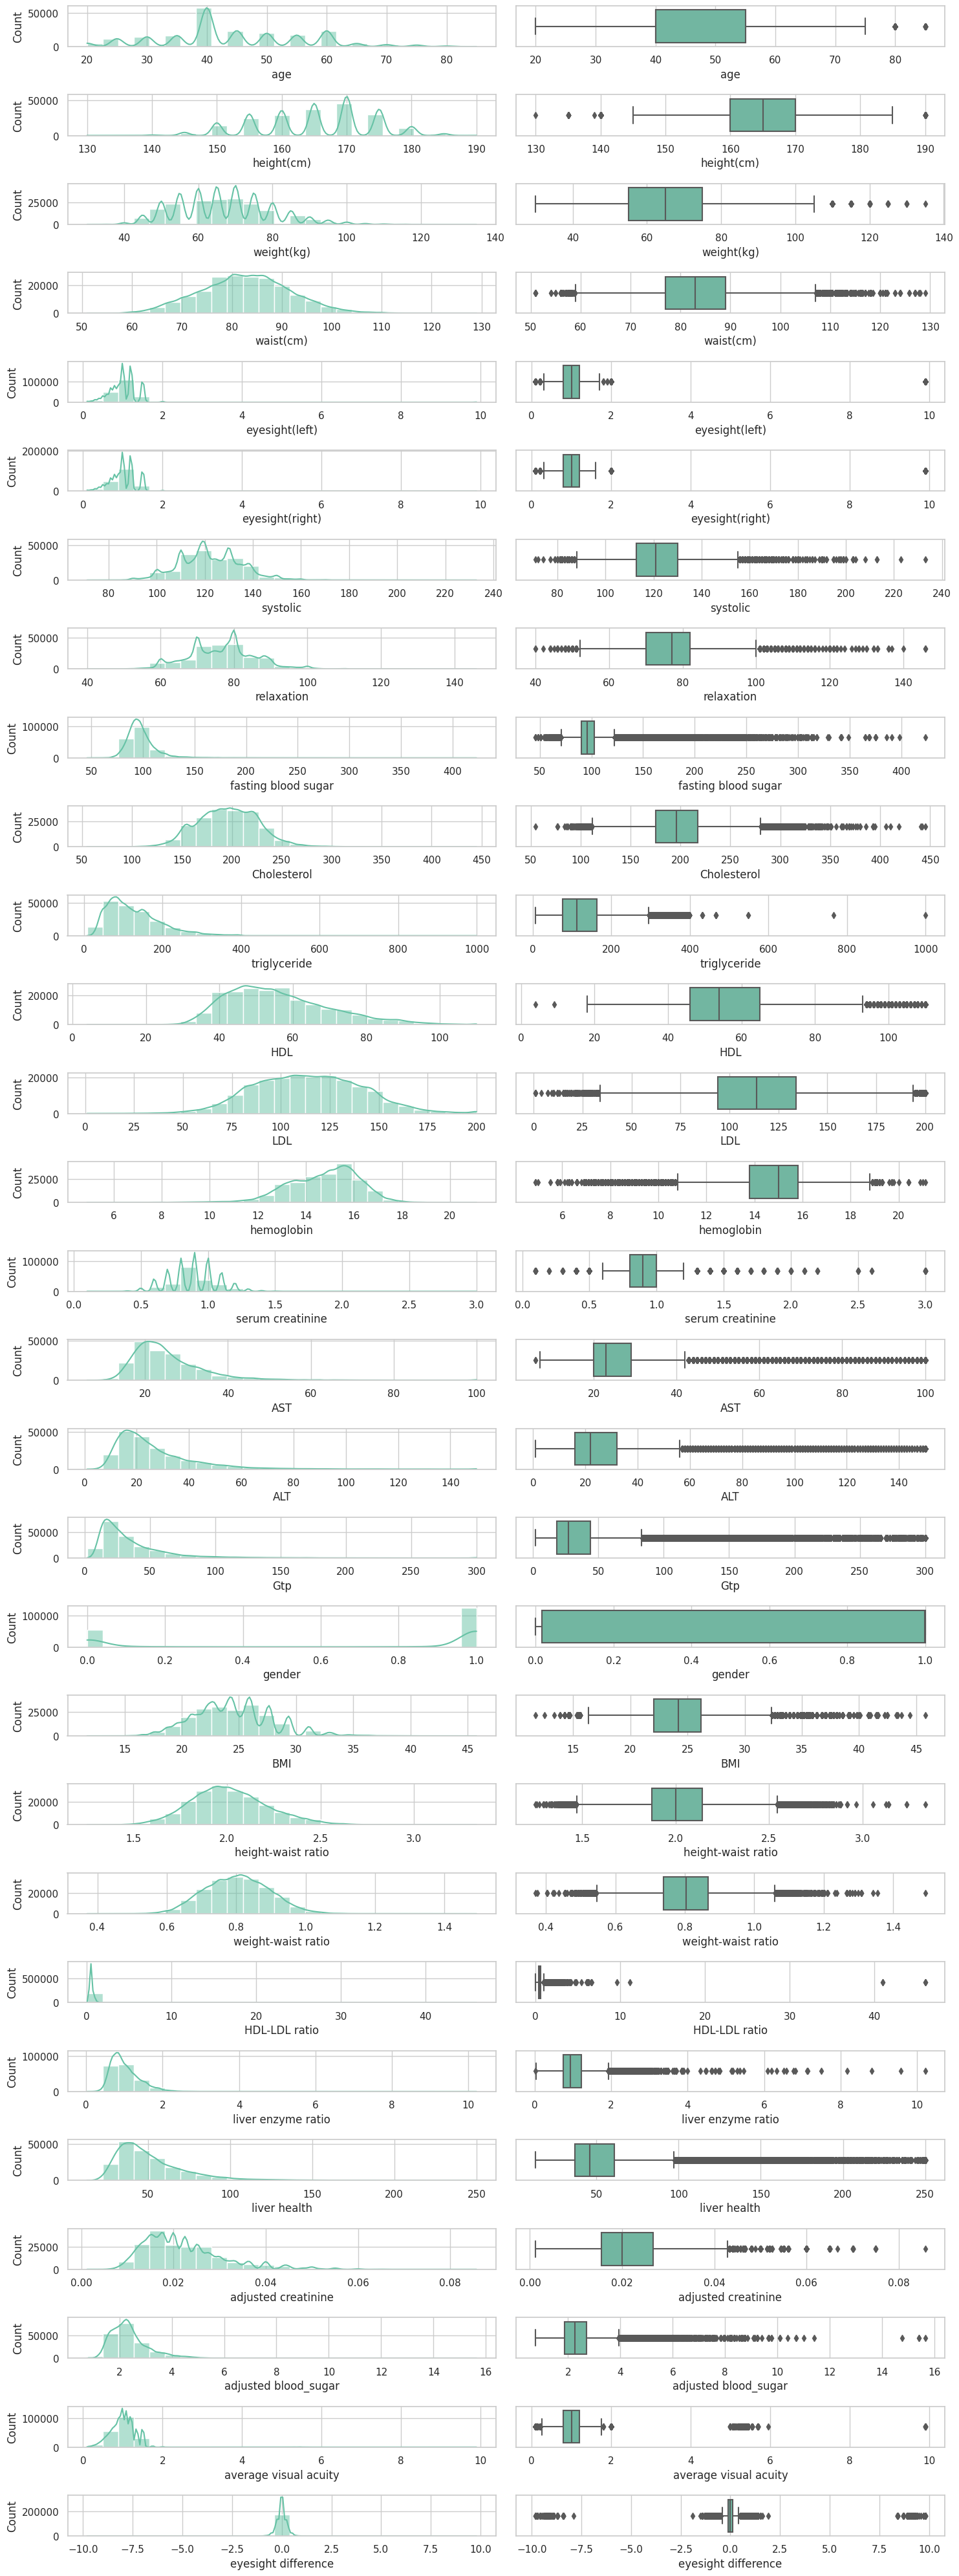

In [28]:
# Specify rows and columns
nrows, ncols = len(num_df.columns), 2
fig, ax = plt.subplots(nrows, ncols, figsize = (15, 40))

# Iterate through columns
for idx, col in enumerate(num_df.columns):
    
    plt.subplot(nrows, ncols, 2*idx+1)
    sns.histplot(data = num_df, x = col, bins = 25, kde = True)
    
    plt.subplot(nrows, ncols, 2*idx+2)
    sns.boxplot(data = num_df, x = col, orient = 'h')

fig.tight_layout()
plt.show()

## 3.3. Categorical Columns

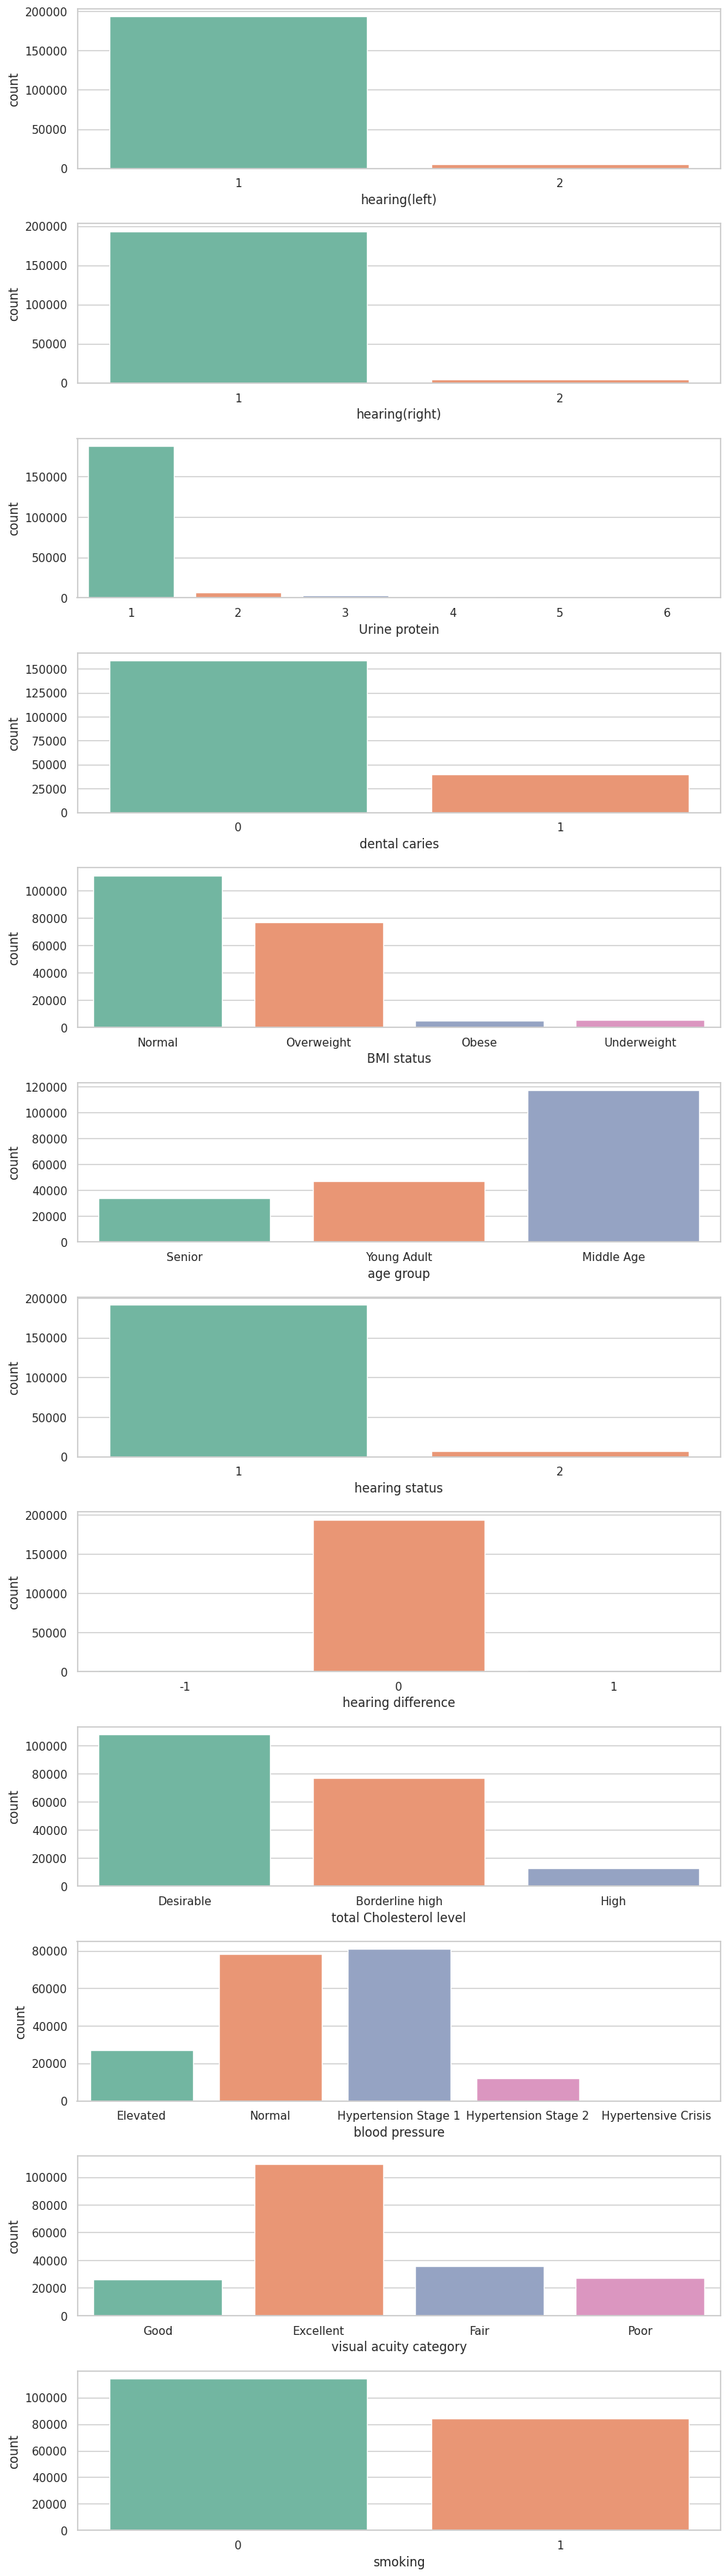

In [29]:
fig, ax = plt.subplots(len(cat_df.columns), 1, figsize=(10, 35))

for i in range(len(cat_df.columns)):
    sns.countplot(data=cat_df, x=cat_df.columns[i], ax=ax[i])

plt.tight_layout()
plt.show()

## 3.3. Feature Relationships

In [30]:
def box_and_barplot(data, x, y, hue = None, orient = 'h', figsize = (8, 5)):
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    sns.boxplot(data, x=x, y=y, hue = hue, ax = ax[0])
    sns.barplot(data, x=x, y=y, ax = ax[1])
    fig.tight_layout()
    plt.show()

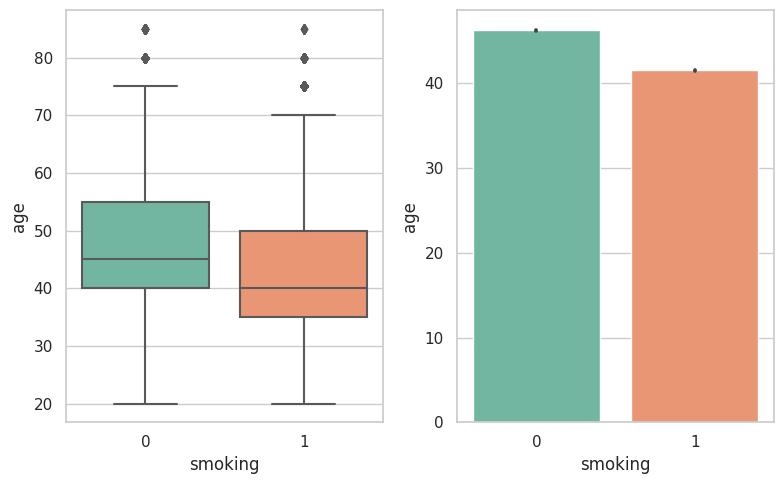

In [31]:
# Smoking vs Age
box_and_barplot(train_data, 'smoking', 'age')

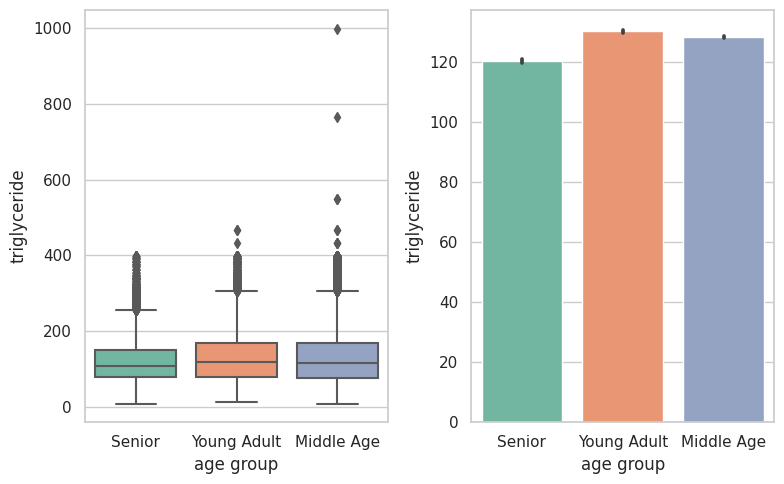

In [32]:
# Age group vs Triglyceride
box_and_barplot(train_data, 'age group', 'triglyceride')

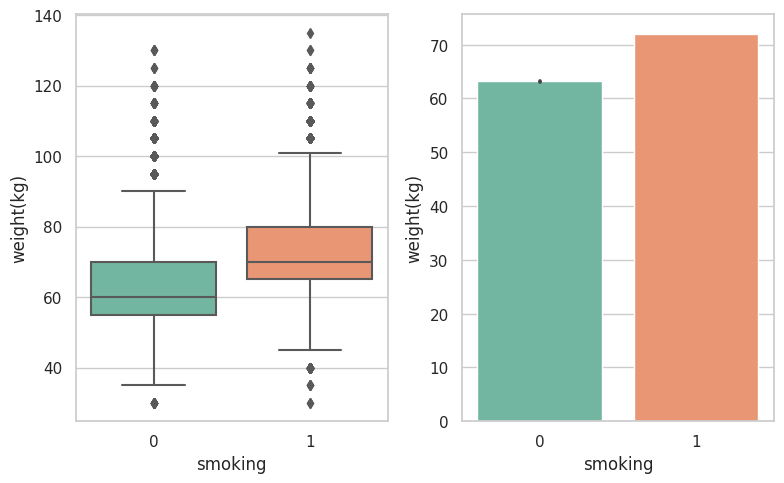

In [33]:
# Smoking vs Weight(kg)
box_and_barplot(train_data, 'smoking', 'weight(kg)')

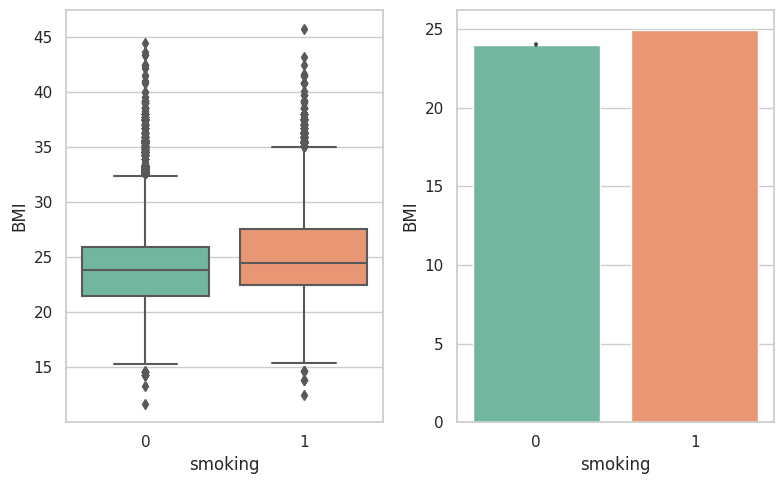

In [34]:
# Smoking vs BMI
box_and_barplot(train_data, 'smoking', 'BMI')

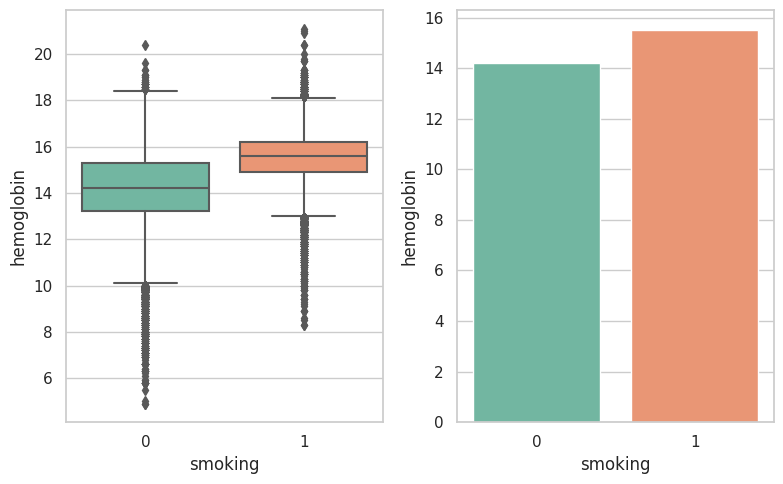

In [35]:
# Smoking vs Hemoglobin
box_and_barplot(train_data, 'smoking', 'hemoglobin')

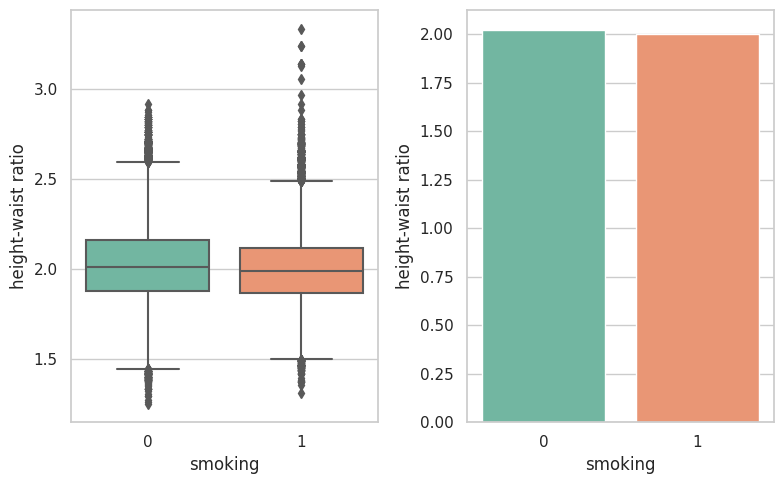

In [36]:
# Smoking vs Height-Waist Ratio
box_and_barplot(train_data, 'smoking', 'height-waist ratio')

<Axes: xlabel='age group', ylabel='smoking'>

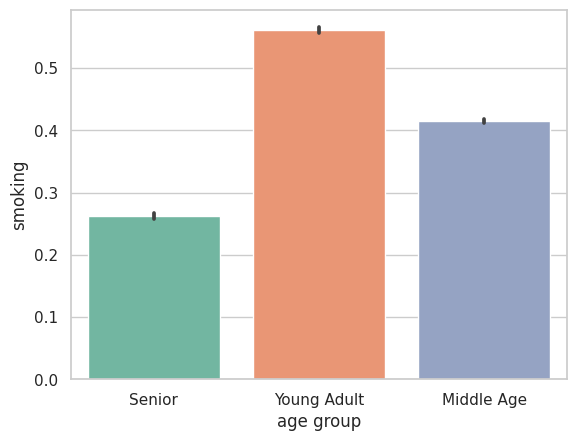

In [37]:
# Age group vs Smoking
sns.barplot(train_data, x = 'age group', y = 'smoking')

<Axes: xlabel='age group', ylabel='hemoglobin'>

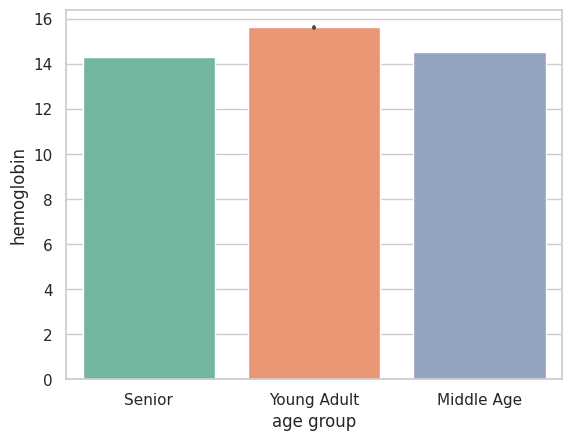

In [38]:
# Age group vs Hemoglobin
sns.barplot(train_data, x = 'age group', y = 'hemoglobin')

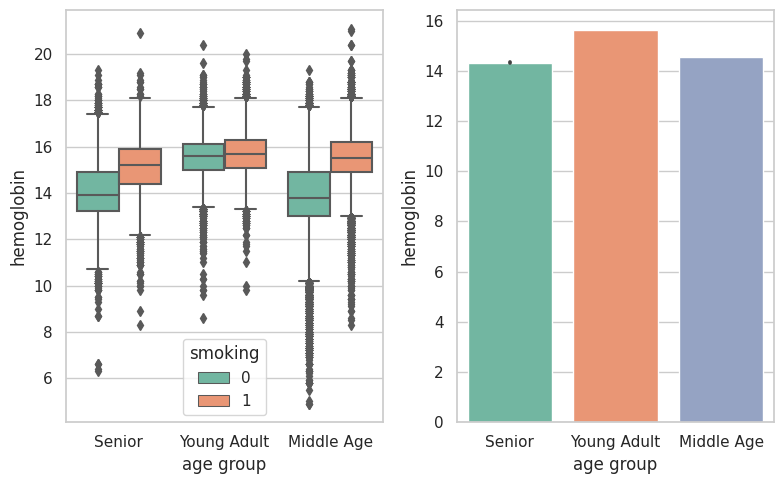

In [39]:
# Smokers per Age group vs Hemoglobin
box_and_barplot(train_data, 'age group', 'hemoglobin', hue = 'smoking')

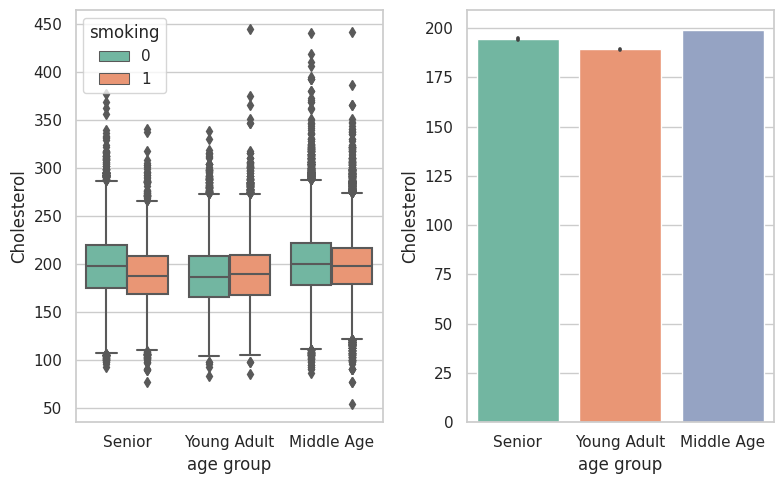

In [40]:
# Smokers per Age group vs Cholesterol
box_and_barplot(train_data, 'age group', 'Cholesterol', hue = 'smoking')

<Axes: xlabel='Cholesterol', ylabel='LDL'>

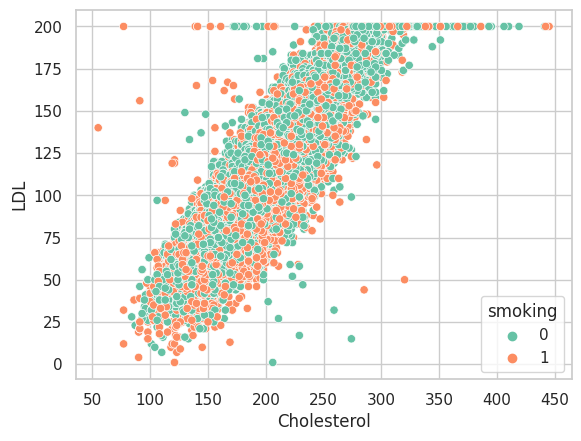

In [41]:
sns.scatterplot(train_data, x = 'Cholesterol', y = 'LDL', hue = 'smoking')

<Axes: xlabel='systolic', ylabel='relaxation'>

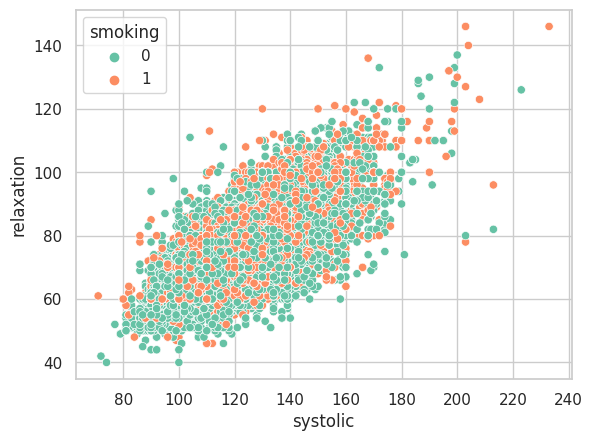

In [42]:
sns.scatterplot(train_data, x = 'systolic', y = 'relaxation', hue = 'smoking')

<Axes: xlabel='BMI', ylabel='Cholesterol'>

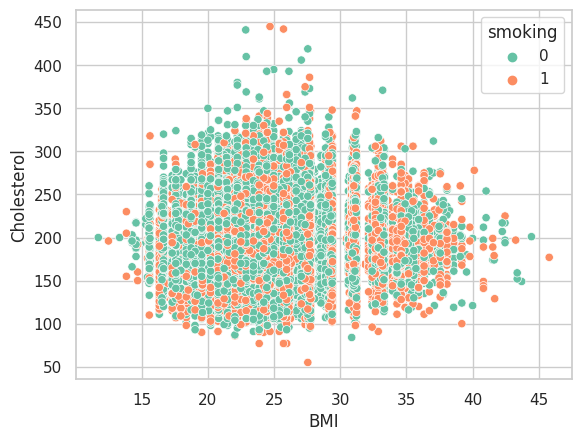

In [43]:
sns.scatterplot(train_data, x = 'BMI', y = 'Cholesterol', hue = 'smoking')

<Axes: xlabel='age', ylabel='Cholesterol'>

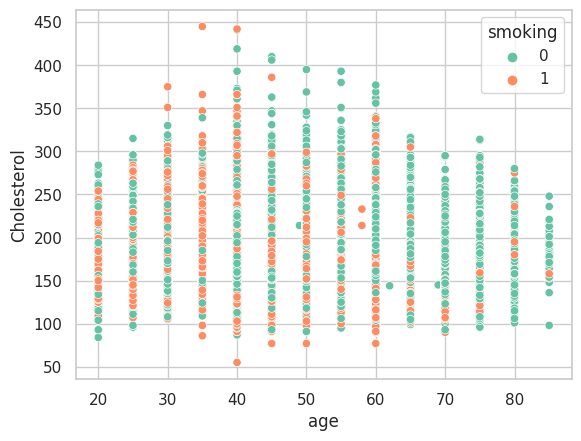

In [44]:
sns.scatterplot(train_data, x = 'age', y = 'Cholesterol', hue = 'smoking')

<Axes: xlabel='age', ylabel='triglyceride'>

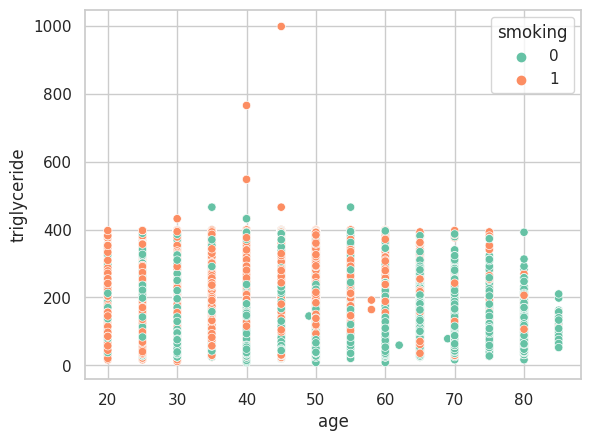

In [45]:
sns.scatterplot(train_data, x = 'age', y = 'triglyceride', hue = 'smoking')

<Axes: >

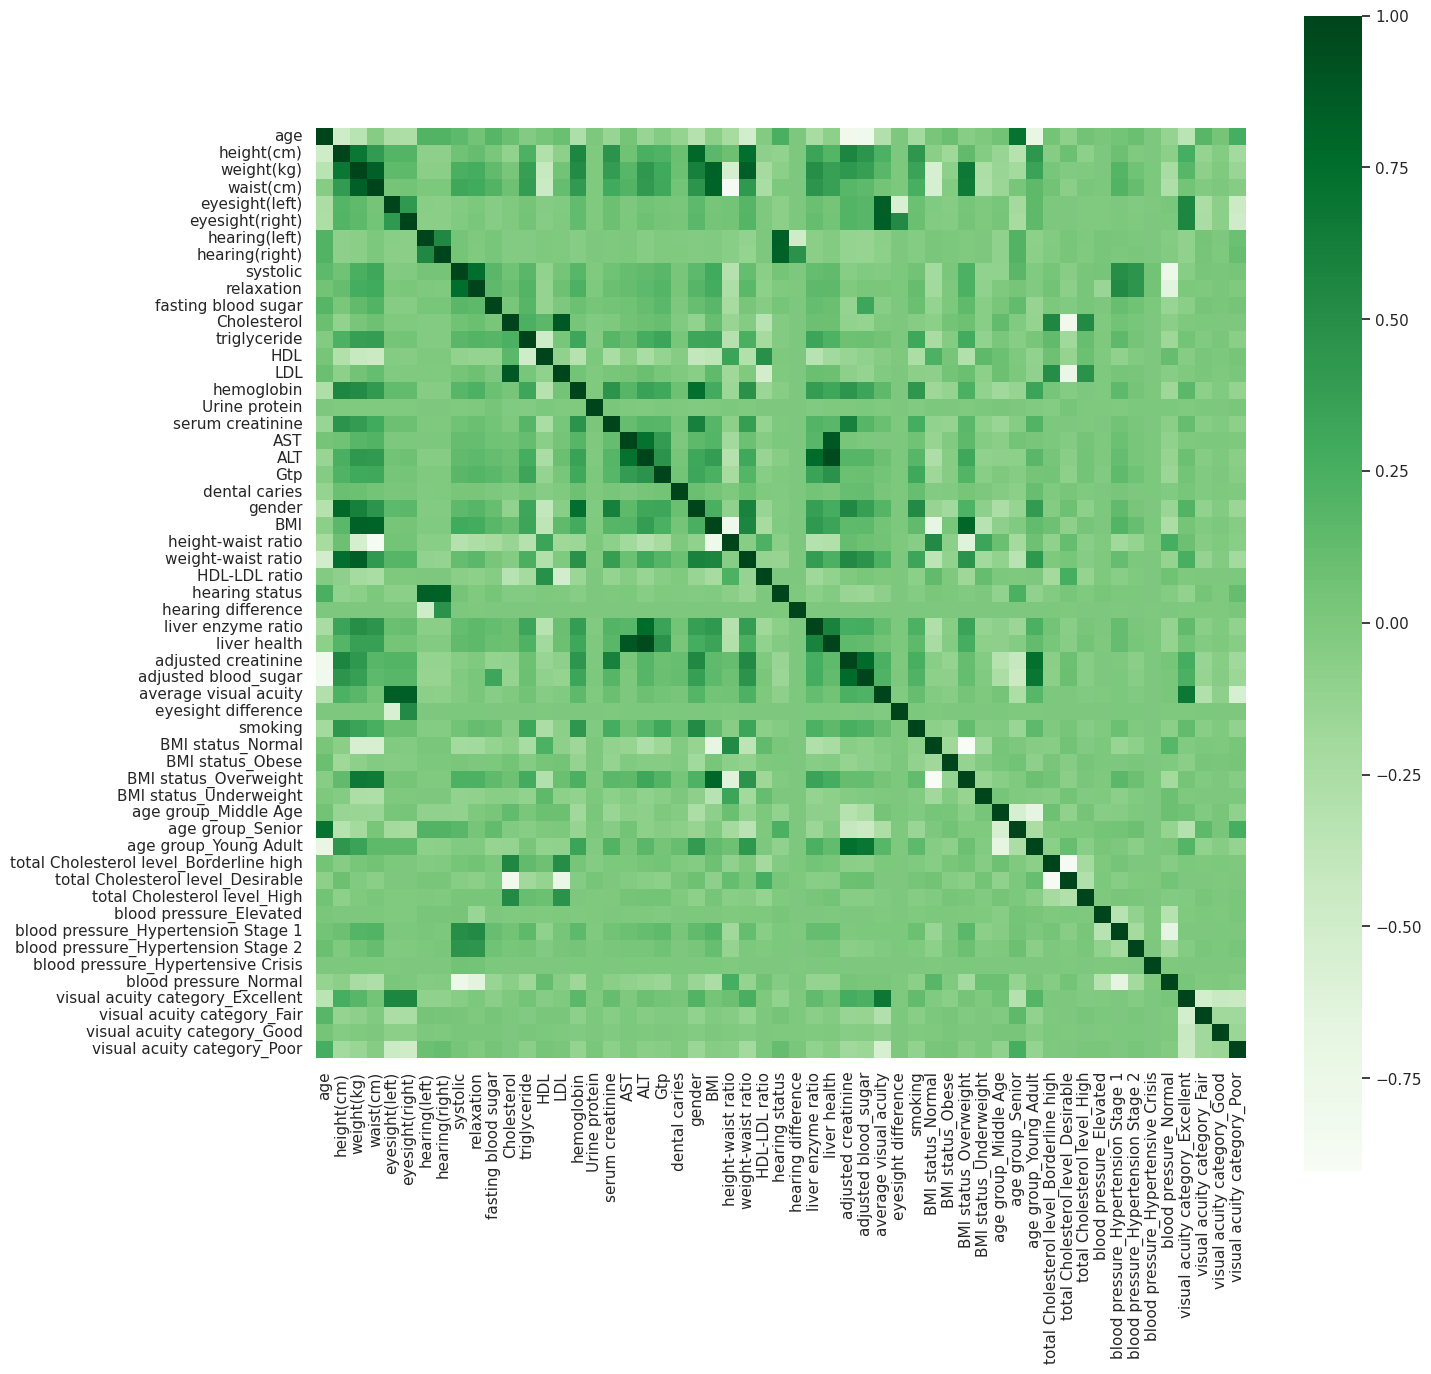

In [46]:
plt.figure(figsize = (15, 15))
sns.heatmap(pd.get_dummies(train_data).corr(), square = True, fmt = '.2f', cmap = 'Greens', annot_kws={"size": 8})

<Axes: >

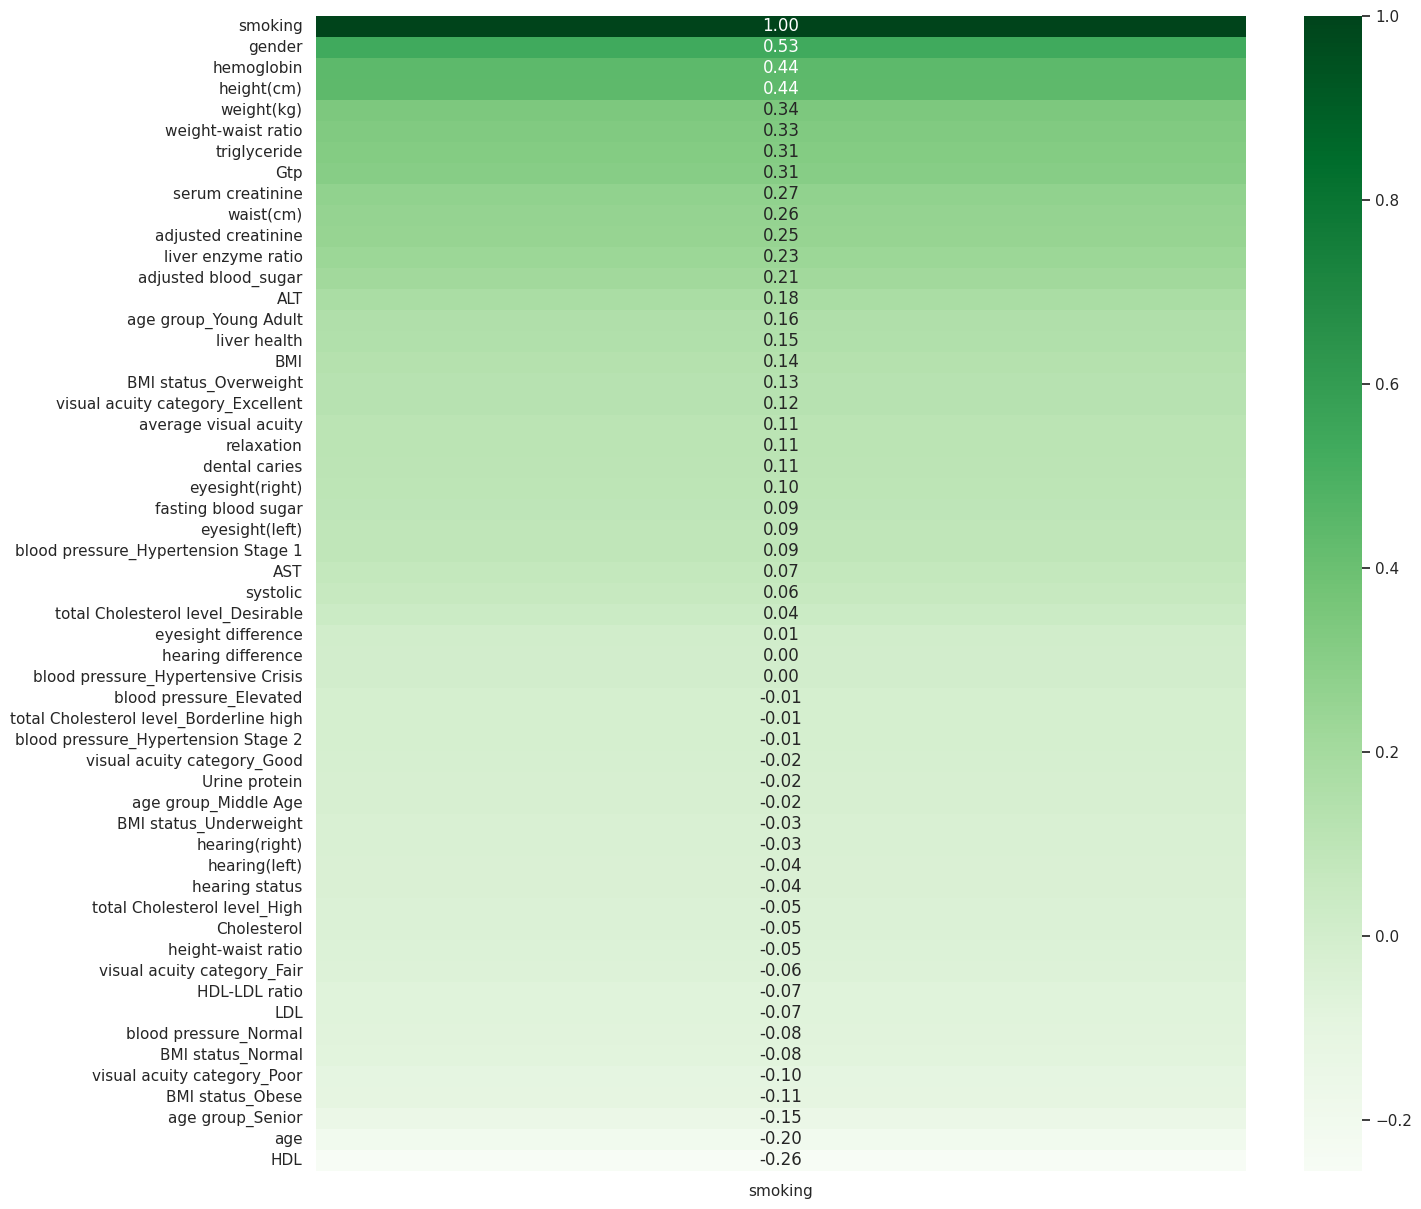

In [47]:
# High correlation to target (smoking)
plt.figure(figsize = (15, 15))
corr_smoking = pd.get_dummies(train_data).corr()['smoking'].sort_values(ascending = False).to_frame()
sns.heatmap(corr_smoking, cmap = 'Greens', fmt = '.2f', annot = True)

# 4. Modelling

## Optuna Tuning

In [48]:
lgbm_best_params = {'n_estimators': 640,
 'max_depth': 9,
 'learning_rate': 0.06943667152224417,
 'min_child_weight': 1.6416909313888723,
 'min_child_samples': 147,
 'subsample': 0.7248525844917247,
 'subsample_freq': 0,
 'colsample_bytree': 0.21160945999785985,
 'num_leaves': 123}

xgb_best_params = {'max_depth': 9,
 'learning_rate': 0.036721165582146276,
 'n_estimators': 981,
 'min_child_weight': 4,
 'gamma': 0.00030782494388328647,
 'subsample': 0.9985665073018731,
 'colsample_bytree': 0.1520744163888843,
 'reg_alpha': 0.0001382856498608154,
 'reg_lambda': 1.85421564876286e-05}

hgb_best_params = {'l2_regularization': 1.0368261454429688e-09,
 'learning_rate': 0.09850187323799647,
 'max_iter': 1000,
 'max_depth': 13,
 'max_bins': 204,
 'min_samples_leaf': 2053,
 'max_leaf_nodes': 33}

In [49]:
cat_base = CatBoostClassifier(verbose = False)
xgb_base = XGBClassifier(**xgb_best_params)
lgbm_base = LGBMClassifier(**lgbm_best_params, verbosity = -1)
hgbc_base = HistGradientBoostingClassifier(**hgb_best_params)

In [50]:
# Split features and labels
X = train_data.drop('smoking', axis = 1)
y = train_data['smoking']

X.shape, y.shape

((198240, 40), (198240,))

In [51]:
X.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'gender', 'BMI', 'BMI status',
       'height-waist ratio', 'weight-waist ratio', 'HDL-LDL ratio',
       'age group', 'hearing status', 'hearing difference',
       'total Cholesterol level', 'blood pressure', 'liver enzyme ratio',
       'liver health', 'adjusted creatinine', 'adjusted blood_sugar',
       'average visual acuity', 'visual acuity category',
       'eyesight difference'],
      dtype='object')

In [52]:
# Encoding categorical columns: OneHot and Ordinal
onehot_cols = ['hearing(left)', 'hearing(right)', 'Urine protein', 'age group']
ordinal_cols = ['hearing difference', 'hearing status','total Cholesterol level', 
                'blood pressure', 'visual acuity category', 'BMI status', 'dental caries']

column_trans = make_column_transformer((OneHotEncoder(), onehot_cols),
                                       (OrdinalEncoder(), ordinal_cols),
                                       remainder = 'passthrough')

X_trans = column_trans.fit_transform(X)
y = np.array(y)

In [53]:
X.shape, X_trans.shape

((198240, 40), (198240, 49))

In [54]:
# Make a copy of features dataframe to use as a reference to  call when plotting feature importances
X_copy = pd.get_dummies(X, columns = onehot_cols)
X_copy.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,hearing(right)_2,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,Urine protein_5,Urine protein_6,age group_Middle Age,age group_Senior,age group_Young Adult
0,60,150,50,78.0,0.8,1.0,121,72,90,183,...,False,True,False,False,False,False,False,False,True,False
1,25,170,65,81.2,1.2,0.8,100,68,95,183,...,False,False,True,False,False,False,False,False,False,True
2,55,165,70,85.0,0.8,0.8,136,80,124,213,...,False,True,False,False,False,False,False,True,False,False
3,40,170,65,82.0,0.7,1.0,126,75,116,135,...,False,True,False,False,False,False,False,True,False,False
4,60,180,110,109.2,1.0,0.9,121,69,97,146,...,False,True,False,False,False,False,False,False,True,False


In [55]:
random_seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
r_scaler = RobustScaler()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = 0.2, random_state = random_seed)

X_train = r_scaler.fit_transform(X_train)
X_test = r_scaler.fit_transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

print(f'Currently using: {device}')

Currently using: cuda


In [56]:
X_train.shape[1], y_train.shape[0]

(49, 158592)

In [57]:
from torch.utils.data import Dataset, DataLoader
class BinarySmoker(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Create ANN
class ANN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units = 32):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features = in_shape, 
                      out_features = hidden_units), # 64
            nn.ReLU(),
            
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(0.2), 
            
            nn.Linear(in_features = hidden_units, # 64  
                      out_features = hidden_units*2), # 128
            nn.ReLU(),
            
            nn.BatchNorm1d(hidden_units*2), # 128
            nn.Dropout(0.2), 
            
            nn.Linear(in_features = hidden_units*2,
                      out_features = hidden_units),
            
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(0.2),
            
            nn.Linear(in_features = hidden_units, 
                      out_features = out_shape),
        ) 
    def forward(self, x):
        return torch.sigmoid(self.linear_stack(x))
    
ann = ANN(in_shape = X_train[0].shape[0], 
          out_shape = 1).to(device)

loss_fn = nn.BCELoss()
roc_fn = roc_auc_score
optim = torch.optim.Adam(ann.parameters(), lr = 0.0001)

train = BinarySmoker(X_train, y_train)
test = BinarySmoker(X_test, y_test)
    
train_loader = DataLoader(train, batch_size = 32, shuffle = True)
test_loader = DataLoader(test, batch_size = 32, shuffle = False)

In [58]:
def train_step(model, 
              dataloader, 
              optimizer,
              loss_fn,
              roc_fn,
              device):
    
    model.train()
    
    loss, roc_auc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y  = torch.tensor(X, dtype = torch.float32).to(device), torch.tensor(y, dtype = torch.float32).to(device)
        
        logits = model(X)
        
        train_loss = loss_fn(logits.squeeze(), y)
        loss += train_loss
        roc_auc += roc_fn(y.cpu(), logits.cpu().detach().numpy().squeeze())
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    loss /= len(dataloader)
    roc_auc /= len(dataloader)
    
    print(f'Training: -- Loss: {loss.item():.4f}, ROC AUC: {roc_auc:.4f}\n')

def test_step(model,
             dataloader,
             loss_fn,
             roc_fn,
             device):
    
    model.eval()
    
    loss, roc_auc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y  = torch.tensor(X, dtype = torch.float32).to(device), torch.tensor(y, dtype = torch.float32).to(device)
            
            logits = model(X)
            loss += loss_fn(logits.squeeze(), y)
            roc_auc += roc_fn(y.cpu(), logits.cpu().detach().numpy().squeeze())
        
        loss /= len(dataloader)
        roc_auc /= len(dataloader)
        
        print(f'Testing -- Loss: {loss:.4f}, ROC AUC: {roc_auc:.4f}\n')
        
epochs = 50

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    print('-'*30+'\n')
    
    train_step(model = ann, 
              dataloader = train_loader,
              optimizer = optim, 
              loss_fn = loss_fn, 
              roc_fn = roc_fn, 
              device = device)
    
    test_step(model = ann, 
             dataloader = test_loader,
             loss_fn = loss_fn,
             roc_fn = roc_fn,
             device = device)

Epoch: 0
------------------------------

Training: -- Loss: 0.5223, ROC AUC: 0.8091

Testing -- Loss: 0.4725, ROC AUC: 0.8449

Epoch: 1
------------------------------

Training: -- Loss: 0.4842, ROC AUC: 0.8391

Testing -- Loss: 0.4642, ROC AUC: 0.8500

Epoch: 2
------------------------------

Training: -- Loss: 0.4782, ROC AUC: 0.8442

Testing -- Loss: 0.4620, ROC AUC: 0.8520

Epoch: 3
------------------------------

Training: -- Loss: 0.4738, ROC AUC: 0.8474

Testing -- Loss: 0.4597, ROC AUC: 0.8532

Epoch: 4
------------------------------

Training: -- Loss: 0.4723, ROC AUC: 0.8490

Testing -- Loss: 0.4595, ROC AUC: 0.8537

Epoch: 5
------------------------------

Training: -- Loss: 0.4707, ROC AUC: 0.8501

Testing -- Loss: 0.4589, ROC AUC: 0.8546

Epoch: 6
------------------------------

Training: -- Loss: 0.4705, ROC AUC: 0.8505

Testing -- Loss: 0.4581, ROC AUC: 0.8549

Epoch: 7
------------------------------

Training: -- Loss: 0.4695, ROC AUC: 0.8512

Testing -- Loss: 0.4588, R

In [59]:
scaler = StandardScaler()
r_scaler = RobustScaler()

base_models = [(cat_base, 'CatBoost'),
               (lgbm_base, 'LGBM'),
               (xgb_base, 'XGBoost'),
               (hgbc_base, 'HistGradientBoost')]

In [60]:
def cross_validate(models, X, y, n_splits = 10, n_repeats = 1, shuffle = True, scaler = None, random_seed = None, pred_probs = False, return_preds = False):
    metric_dict, oof_preds = {}, {}
    rsk = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = random_seed)
    
    X_data, y_data = list(), list()
    
    #  cross-validation
    for idx, (train_idx, test_idx) in enumerate(rsk.split(X, y)):
        print(f'Training on Fold #{idx+1}')
        print('-'*30)
        
        # create train and test splits
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale data if scaler is available
        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            print(f'Scaler: {scaler}')
        
        # Keep track of features and labels per fold
        X_data.extend(X_test)
        y_data.extend(y_test)
        
        # Fit model and make predictions
        for model in models: 
            model[0].fit(X_train, y_train)
            
            # Return prediction labels
            if pred_probs == False:
                y_pred = model[0].predict(X_test)
                
                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                # Store metrics in dictionary
                if model[1] not in metric_dict:
                    metric_dict[model[1]]  = {'acc' : [],
                                              'f1' : []}
                    oof_preds[model[1]] = []
                
                metric_dict[model[1]]['acc'].append(acc)
                metric_dict[model[1]]['f1'].append(f1)
                
                print(f'\n[{model[1]}] Accuracy: {acc:.4f} | F1: {f1:.4f}')
                
            # Return prediction probabilities
            else:
                y_pred = model[0].predict_proba(X_test)[:,1]
                
                roc_auc = roc_auc_score(y_test, y_pred)
                ll = log_loss(y_test, y_pred)
                
                if model[1] not in metric_dict:
                    metric_dict[model[1]] = {'roc_auc' : [],
                                             'log_loss' : []}
                    oof_preds[model[1]] = []
                
                metric_dict[model[1]]['roc_auc'].append(roc_auc)
                metric_dict[model[1]]['log_loss'].append(ll)
            
                print(f'\n[{model[1]}] ROC AUC: {roc_auc:.4f} | Log Loss: {ll:.4f}')
                
            oof_preds[model[1]].append(y_pred)
            
        print('\n')
        
    if return_preds != False:
        return metric_dict, oof_preds, (X_data, y_data)
    else:
        return metric_dict

In [61]:
metric_dict, oof_scores, oof_test_data = cross_validate(base_models, 
                                                         X_trans, 
                                                         y, 
                                                         n_splits = 10, 
                                                         scaler = r_scaler, 
                                                         random_seed = random_seed, 
                                                         pred_probs = True, 
                                                         return_preds = True)

Training on Fold #1
------------------------------
Scaler: RobustScaler()

[CatBoost] ROC AUC: 0.8728 | Log Loss: 0.4332

[LGBM] ROC AUC: 0.8763 | Log Loss: 0.4276

[XGBoost] ROC AUC: 0.8790 | Log Loss: 0.4233

[HistGradientBoost] ROC AUC: 0.8712 | Log Loss: 0.4341


Training on Fold #2
------------------------------
Scaler: RobustScaler()

[CatBoost] ROC AUC: 0.8675 | Log Loss: 0.4383

[LGBM] ROC AUC: 0.8719 | Log Loss: 0.4317

[XGBoost] ROC AUC: 0.8745 | Log Loss: 0.4284

[HistGradientBoost] ROC AUC: 0.8664 | Log Loss: 0.4388


Training on Fold #3
------------------------------
Scaler: RobustScaler()

[CatBoost] ROC AUC: 0.8689 | Log Loss: 0.4364

[LGBM] ROC AUC: 0.8735 | Log Loss: 0.4306

[XGBoost] ROC AUC: 0.8758 | Log Loss: 0.4277

[HistGradientBoost] ROC AUC: 0.8669 | Log Loss: 0.4389


Training on Fold #4
------------------------------
Scaler: RobustScaler()

[CatBoost] ROC AUC: 0.8670 | Log Loss: 0.4408

[LGBM] ROC AUC: 0.8711 | Log Loss: 0.4350

[XGBoost] ROC AUC: 0.8746 | Log

In [62]:
ann.eval()
with torch.inference_mode():
    ann_preds = ann(torch.tensor(oof_test_data[0], dtype = torch.float32).to(device))
ann_preds, ann_preds.shape

(tensor([[0.6372],
         [0.0977],
         [0.0868],
         ...,
         [0.8578],
         [0.0759],
         [0.5975]], device='cuda:0'),
 torch.Size([198240, 1]))

In [63]:
def calculate_oof_metric(dict, model_name, metric):
    return np.mean(dict[model_name][metric])

def display_oof_metrics(dict, return_dict = False):
    oof_metrics = {'models':[]}
    # Create model metrics entry in dictionary
    for model_name in list(dict.keys()):
        if model_name not in oof_metrics['models']:
            oof_metrics['models'].append(model_name)
        print(model_name)
        print('-'*30)
        for metric in list(dict[model_name].keys()):
            if metric not in oof_metrics:
                oof_metrics[metric] = []
                
            # Get oof metrics
            oof_metric = calculate_oof_metric(dict, model_name, metric)
            oof_metrics[metric].append(oof_metric)
            
            print(f'oof_{metric}: {oof_metric}')
        print('\n') 
    if return_dict:
        return oof_metrics

def create_metrics_df(dict, sort_by = None, ascending = False):
    metrics_df = pd.DataFrame()
    for key in list(dict.keys())[1:]:
        metrics_df[key] = dict[key]
    metrics_df.index = dict['models']
    if sort_by is not None:
        metrics_df = metrics_df.sort_values(by = sort_by, ascending = ascending)
    return metrics_df

def create_preds_df(dict):
    score_df = pd.DataFrame()
    for key in list(dict.keys()):
        score_df[key] = np.concatenate(dict[key])
    return score_df

In [64]:
oof_metrics = display_oof_metrics(metric_dict, return_dict = True)

CatBoost
------------------------------
oof_roc_auc: 0.8689526395735607
oof_log_loss: 0.438321195378931


LGBM
------------------------------
oof_roc_auc: 0.8734315448423242
oof_log_loss: 0.43189086821462574


XGBoost
------------------------------
oof_roc_auc: 0.8761104007303769
oof_log_loss: 0.42833122003854773


HistGradientBoost
------------------------------
oof_roc_auc: 0.8680126688517212
oof_log_loss: 0.4390571907974431




In [65]:
metrics_df = create_metrics_df(oof_metrics, sort_by = 'roc_auc')
metrics_df

,roc_auc,log_loss
XGBoost,0.876110,0.428331
LGBM,0.873432,0.431891
CatBoost,0.868953,0.438321
HistGradientBoost,0.868013,0.439057


In [66]:
selected_models = [(lgbm_base, 'LGBM'),
                   (xgb_base, 'XGBoost'),
                   (cat_base, 'CatBoost')]

In [67]:
test_trans = column_trans.transform(test_data)
test_trans.shape

(106171, 49)

In [68]:
model_names = [model[1] for model in selected_models]
scores_df = create_preds_df(oof_scores)
scores_df = scores_df[model_names]
scores_df.head()

,LGBM,XGBoost,CatBoost
0,0.449927,0.550060,0.593199
1,0.042637,0.047917,0.046891
2,0.083071,0.078681,0.077396
3,0.312327,0.398366,0.286302
4,0.517047,0.650611,0.501227


In [69]:
np.concatenate(oof_scores['CatBoost']).shape

(198240,)

In [70]:
from sklearn.linear_model import LogisticRegression

# Take weights from logistic regression
# Idea from Simarpeet Singh's notebook: 
# https://www.kaggle.com/code/cybersimar08/ps-s3e24-eda-optuna-cat-xgb-lgbm

oof_weights_logreg = LogisticRegression(random_state = random_seed).fit(scores_df, oof_test_data[1]).coef_[0]
pd.DataFrame(oof_weights_logreg, index = scores_df.columns, columns = ['weight per model'])

,weight per model
LGBM,1.614957
XGBoost,4.506519
CatBoost,-0.335928


In [71]:
def plot_feature_importances(model, features, title, kind = 'barh', figsize = (10, 8)):
    model_feat_imps = model.feature_importances_
    pd.DataFrame(data = model_feat_imps,
                 index = features,
                 columns = ['importance']).sort_values(by = 'importance', ascending = True).plot(kind = 'barh', figsize = figsize, title = title, fontsize = 8)

In [72]:
def ensemble_predict(models, data, to_predict, weights, verbose = False, labels = None):
    model_preds, preds = {}, 0
    
    # fit model on `data` and make predictions on `x`
    for model in models:
        model[0].fit(data[0], data[1])
        y_pred = model[0].predict_proba(to_predict)[:,1]
        
        if labels is not None and verbose is not False:
            print(f'[{model[1]}] ROC AUC: {roc_auc_score(labels, y_pred):.5f} | Log Loss: {log_loss(labels, y_pred):.5f}\n')
        
        # store each model's predictions in dictionary
        if model[1] not in model_preds:
            model_preds[model[1]] = y_pred
            
    # weighted average
    for idx, model in enumerate(model_preds.keys()):        
        preds += weights[idx] * np.array(model_preds[model])
    
    preds /= np.sum(weights)
    
    return preds

In [73]:
logreg_ensem_preds = []
# manual_ensem_preds = []
weighted_ensem_scores = {}

sk = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_seed)

for idx, (train_idx, test_idx) in enumerate(sk.split(X_trans, y)):
    print(f'Fold #{idx+1}')
    print('-'*30+'\n')
    
    x_train, x_test = X_trans[train_idx], X_trans[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    x_train = r_scaler.fit_transform(x_train)
    x_test = r_scaler.transform(x_test)
    
    for item in ['logreg', 'manual']:
        if item not in weighted_ensem_scores:
            weighted_ensem_scores[item] = {'roc_auc': [],
                                           'log_loss':[]}
    
    logreg_preds = ensemble_predict(selected_models, 
                                    (x_train, y_train),
                                     x_test,
                                     oof_weights_logreg,
                                     y_test)
    logreg_ensem_preds.append(logreg_preds)
    
    logreg_roc_auc = roc_auc_score(y_test, logreg_preds)
    logreg_log_loss = log_loss(y_test, logreg_preds)
    
    weighted_ensem_scores['logreg']['roc_auc'].append(logreg_roc_auc)
    weighted_ensem_scores['logreg']['log_loss'].append(logreg_log_loss)
    print(f'[LogReg Weighted Average] ROC AUC: {logreg_roc_auc:.5f} | Log Loss: {logreg_log_loss:.5f}\n')
    
#     manual_preds = ensemble_predict(selected_models, 
#                                     (x_train, y_train),
#                                     x_test,
#                                     oof_weights_manual,
#                                     y_test)
#     manual_ensem_preds.append(manual_preds)
    
#     manual_roc_auc = roc_auc_score(y_test, manual_preds)
#     manual_log_loss = log_loss(y_test, manual_preds)
    
#     weighted_ensem_scores['manual']['roc_auc'].append(manual_roc_auc)
#     weighted_ensem_scores['manual']['log_loss'].append(manual_log_loss)
#     print(f'[Manual Weighted Average] ROC AUC: {manual_roc_auc:.5f} | Log Loss: {manual_log_loss:.5f}\n\n')
    
logreg_ensem_preds = np.expand_dims(np.concatenate(logreg_ensem_preds), axis = 1)
# manual_ensem_preds = np.expand_dims(np.concatenate(manual_ensem_preds), axis= 1)

Fold #1
------------------------------

[LogReg Weighted Average] ROC AUC: 0.87611 | Log Loss: 0.42682

Fold #2
------------------------------

[LogReg Weighted Average] ROC AUC: 0.87483 | Log Loss: 0.42964

Fold #3
------------------------------

[LogReg Weighted Average] ROC AUC: 0.87355 | Log Loss: 0.43300

Fold #4
------------------------------

[LogReg Weighted Average] ROC AUC: 0.87795 | Log Loss: 0.42660

Fold #5
------------------------------

[LogReg Weighted Average] ROC AUC: 0.87584 | Log Loss: 0.42846



In [74]:
ensem_metrics = display_oof_metrics(weighted_ensem_scores, return_dict = True)

logreg
------------------------------
oof_roc_auc: 0.8756573594048372
oof_log_loss: 0.4289007218987356


manual
------------------------------
oof_roc_auc: nan
oof_log_loss: nan




In [75]:
ensem_metrics_df = create_metrics_df(ensem_metrics, sort_by = 'roc_auc')
ensem_metrics_df

,roc_auc,log_loss
logreg,0.875657,0.428901
manual,NaN,NaN


In [76]:
# Create meta dataset
base_preds = create_preds_df(oof_scores)
X_meta = np.concatenate((np.array(oof_test_data[0]), base_preds[model_names].to_numpy(), logreg_ensem_preds), axis = 1)

X_meta.shape

(198240, 53)

In [77]:
# Fit meta model
meta_model = HistGradientBoostingClassifier(verbose = False)
meta_model.fit(X_meta, oof_test_data[1])

HistGradientBoostingClassifier(verbose=False)

**Weighted Ensemble**: Combines the three predictions from the submodels to form one set of weighted average predictions.

**Meta Model**: Appended the predictions of each model (including the weighted ensemble's) to the training set as new features.

**Weighed Meta**: The weighted average predictions of the weighted ensemble and meta model.

In [78]:
sub_model_preds = {}
meta_oof_preds, w_meta_oof_preds, we_oof_preds = [], [], []

x_data, y_data = list(), list()

rsk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = random_seed)

for idx, (train_idx, test_idx) in enumerate(rsk.split(X_trans, y)):
    print(f'\nTraining on Fold #{idx+1}')
    print('-'*30+'\n')
    
    x_train, x_test = X_trans[train_idx], X_trans[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    x_train = r_scaler.fit_transform(x_train)
    x_test = r_scaler.transform(x_test)
    
    x_data.extend(x_test)
    y_data.extend(y_test)
    
    # =================
    # Weighted Ensemble 
    # =================
    
    we_preds = ensemble_predict(selected_models, 
                                (x_train, y_train),
                                x_test,
                                oof_weights_logreg, # using logreg defined weights
                                y_test) 
    sub_model_preds['weighted_ensemble'] = [we_preds]
    
    we_oof_preds.append(we_preds)
    we_roc_auc = roc_auc_score(y_test, we_preds)
    we_log_loss = log_loss(y_test, we_preds)
    
    print(f'[weighted_ensemble] ROC AUC: {we_roc_auc:.5f} | Log Loss: {we_log_loss:.5f}\n')
    
    # =================
    #    Meta Model 
    # =================
    
    # Fit models and make predictions
    for model in selected_models:
        model[0].fit(x_train, y_train)
        sub_model_preds[model[1]] = [model[0].predict_proba(x_test)[:, 1]]
        
    sub_model_preds_df = create_preds_df(sub_model_preds).to_numpy()
    x_meta = np.concatenate((x_test, sub_model_preds_df), axis = 1)
    
    meta_preds = meta_model.predict_proba(x_meta)[:, 1]
    
    meta_roc_auc = roc_auc_score(y_test, meta_preds)
    meta_log_loss = log_loss(y_test, meta_preds)
    
    print(f'[meta_model] ROC AUC: {meta_roc_auc:.5f} | Log Loss: {meta_log_loss:.5f}\n')
    
    # =================
    #   Weighted Meta 
    # =================
    
    w_meta_preds = (meta_preds*8.5 + we_preds*7.2) / (8.5 + 7.2)
    
    w_meta_roc_auc = roc_auc_score(y_test, w_meta_preds)
    w_meta_log_loss = log_loss(y_test, w_meta_preds)
    
    print(f'[weighted_meta] ROC AUC: {w_meta_roc_auc:.5f} | Log Loss: {w_meta_log_loss:.5f}\n')
    
    w_ensem_w_meta_preds = (we_preds*20.5 + w_meta_preds*20.2) / (20.5 + 20.2)
    
    w_ensem_w_meta_roc_auc = roc_auc_score(y_test, w_ensem_w_meta_preds)
    w_ensem_w_meta_log_loss = log_loss(y_test, w_ensem_w_meta_preds)
    
    print(f'[weighted_avg / weighted_meta] ROC AUC: {w_ensem_w_meta_roc_auc:.5f} | Log Loss: {w_ensem_w_meta_log_loss:.5f}\n')
     
    meta_oof_preds.append(meta_preds)
    w_meta_oof_preds.append(w_meta_preds)


Training on Fold #1
------------------------------

[weighted_ensemble] ROC AUC: 0.87611 | Log Loss: 0.42682

[meta_model] ROC AUC: 0.87553 | Log Loss: 0.42718

[weighted_meta] ROC AUC: 0.87643 | Log Loss: 0.42593

[weighted_avg / weighted_meta] ROC AUC: 0.87648 | Log Loss: 0.42601


Training on Fold #2
------------------------------

[weighted_ensemble] ROC AUC: 0.87483 | Log Loss: 0.42964

[meta_model] ROC AUC: 0.87357 | Log Loss: 0.43052

[weighted_meta] ROC AUC: 0.87473 | Log Loss: 0.42903

[weighted_avg / weighted_meta] ROC AUC: 0.87497 | Log Loss: 0.42898


Training on Fold #3
------------------------------

[weighted_ensemble] ROC AUC: 0.87355 | Log Loss: 0.43300

[meta_model] ROC AUC: 0.87302 | Log Loss: 0.43241

[weighted_meta] ROC AUC: 0.87397 | Log Loss: 0.43135

[weighted_avg / weighted_meta] ROC AUC: 0.87400 | Log Loss: 0.43166


Training on Fold #4
------------------------------

[weighted_ensemble] ROC AUC: 0.87795 | Log Loss: 0.42660

[meta_model] ROC AUC: 0.87794 | Lo

In [79]:
meta_oof_preds_trans = np.concatenate(meta_oof_preds)
w_meta_oof_preds_trans = np.concatenate(w_meta_oof_preds)
we_oof_preds_trans = np.concatenate(we_oof_preds)

meta_oof_preds_trans.shape, w_meta_oof_preds_trans.shape, we_oof_preds_trans.shape

((396480,), (396480,), (396480,))

In [80]:
np.array(y_data).shape, we_preds.shape

((396480,), (39648,))

<Axes: title={'center': 'Meta Model Confusion Matrix'}>

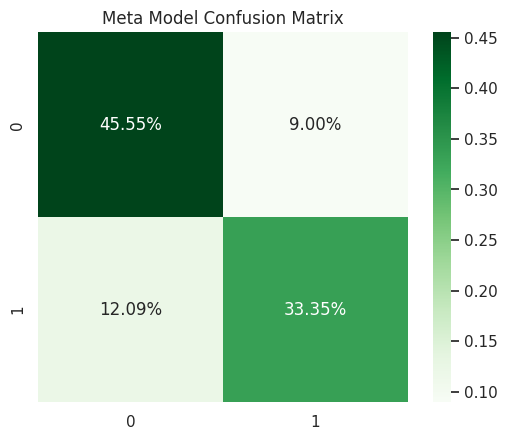

In [81]:
from sklearn.metrics import confusion_matrix

meta_cm = confusion_matrix(np.round(meta_oof_preds_trans), y_data)
plt.title('Meta Model Confusion Matrix')
sns.heatmap(meta_cm/np.sum(meta_cm), annot = True, square = True, cmap = 'Greens', fmt = '.2%')

<Axes: >

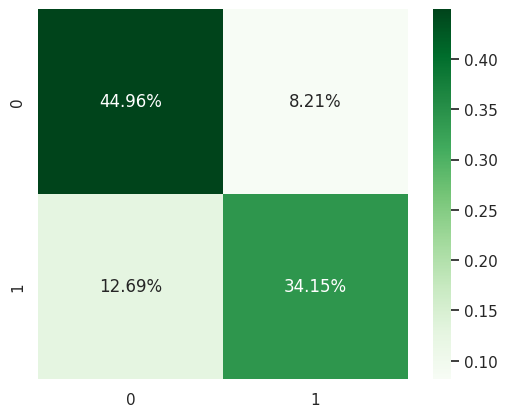

In [82]:
we_cm = confusion_matrix(np.round(we_oof_preds_trans), y_data)
sns.heatmap(we_cm/np.sum(we_cm), annot = True, square = True, cmap = 'Greens', fmt = '.2%')

<Axes: title={'center': 'Weighted Meta Model Confusion Matrix'}>

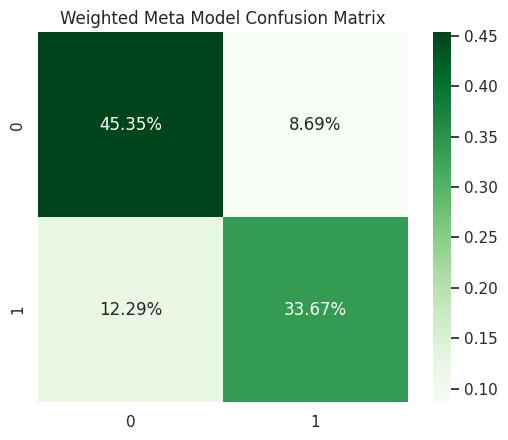

In [83]:
w_meta_cm = confusion_matrix(np.round(w_meta_oof_preds_trans), y_data)
plt.title('Weighted Meta Model Confusion Matrix')
sns.heatmap(w_meta_cm/np.sum(w_meta_cm), annot = True, square = True, cmap = 'Greens', fmt = '.2%')

# Predicting on Test Data

In [84]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = 0.2, random_state = random_seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((158592, 49), (39648, 49), (158592,), (39648,))

In [85]:
X_train = r_scaler.fit_transform(X_train)
X_test = r_scaler.transform(X_test)

X_train.shape, X_test.shape

((158592, 49), (39648, 49))

In [86]:
test_trans.shape

(106171, 49)

In [87]:
sub_model_preds = {}

weight_base_preds = ensemble_predict(selected_models,
                                    (X_train, y_train),
                                    test_trans, 
                                    oof_weights_logreg)
sub_model_preds['weight_average'] = [weight_base_preds]

for model in selected_models:
    model[0].fit(X_train, y_train)
    sub_model_preds[model[1]] = [model[0].predict_proba(test_trans)[:, 1]]

sub_model_preds_df = create_preds_df(sub_model_preds).to_numpy()
x_meta = np.concatenate((test_trans, sub_model_preds_df), axis = 1)

meta_preds = meta_model.predict_proba(x_meta)[:, 1]

In [88]:
weight_base_preds[:10], weight_base_preds.shape

(array([0.84770549, 0.73701522, 0.78138202, 0.81880435, 0.85012359,
        0.82118329, 0.83458553, 0.8417361 , 0.77602503, 0.78956034]),
 (106171,))

In [89]:
meta_preds[:10], meta_preds.shape

(array([0.45217235, 0.30549847, 0.31810469, 0.45111053, 0.47938091,
        0.35962422, 0.46853735, 0.43484499, 0.34026522, 0.37496125]),
 (106171,))

In [90]:
w_meta_preds = (weight_base_preds + meta_preds) / 2
w_meta_preds[:10]

array([0.64993892, 0.52125684, 0.54974336, 0.63495744, 0.66475225,
       0.59040376, 0.65156144, 0.63829055, 0.55814512, 0.58226079])

In [91]:
submission = pd.DataFrame()
submission['id'] = sample_sub['id']
submission['smoking'] = weight_base_preds
submission.head()

,id,smoking
0,159256,0.847705
1,159257,0.737015
2,159258,0.781382
3,159259,0.818804
4,159260,0.850124


In [92]:
# submission.to_csv('we_submission.csv', index = False, header = True)

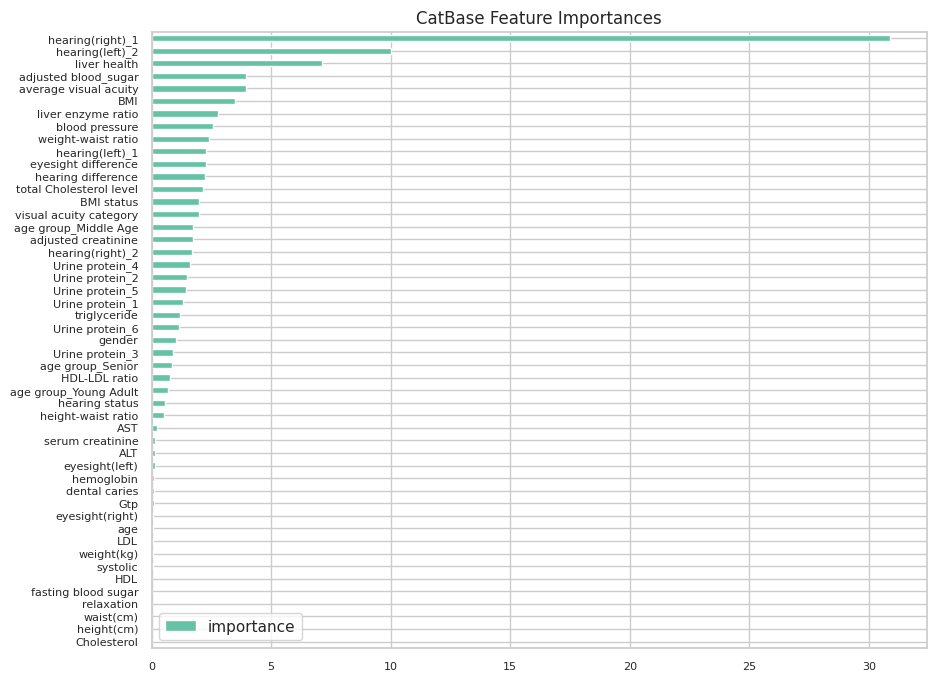

In [93]:
plot_feature_importances(cat_base, X_copy.columns, title = 'CatBase Feature Importances')

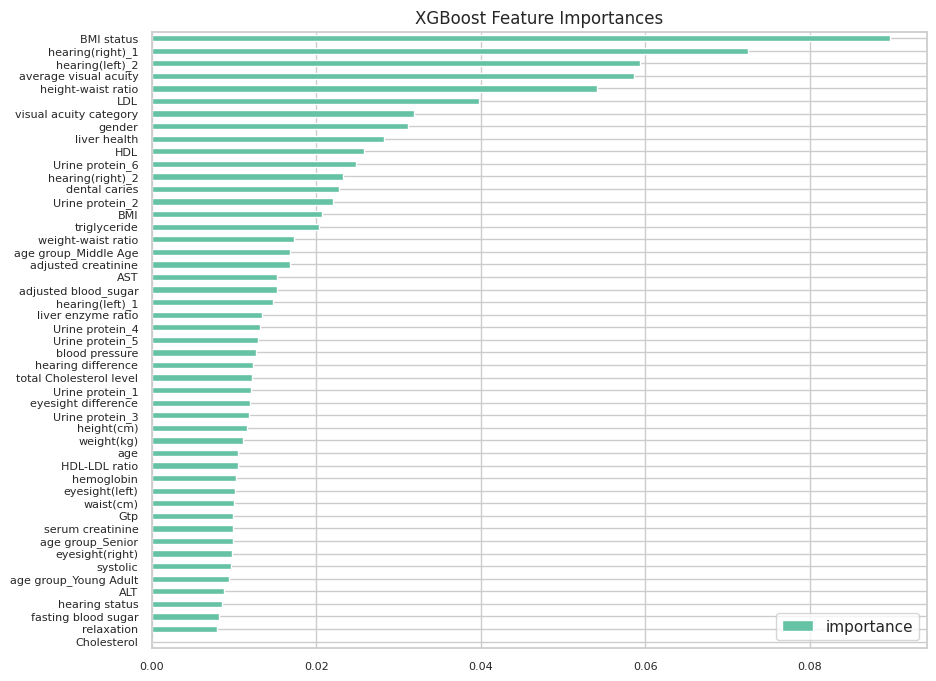

In [94]:
plot_feature_importances(xgb_base, X_copy.columns, 'XGBoost Feature Importances')

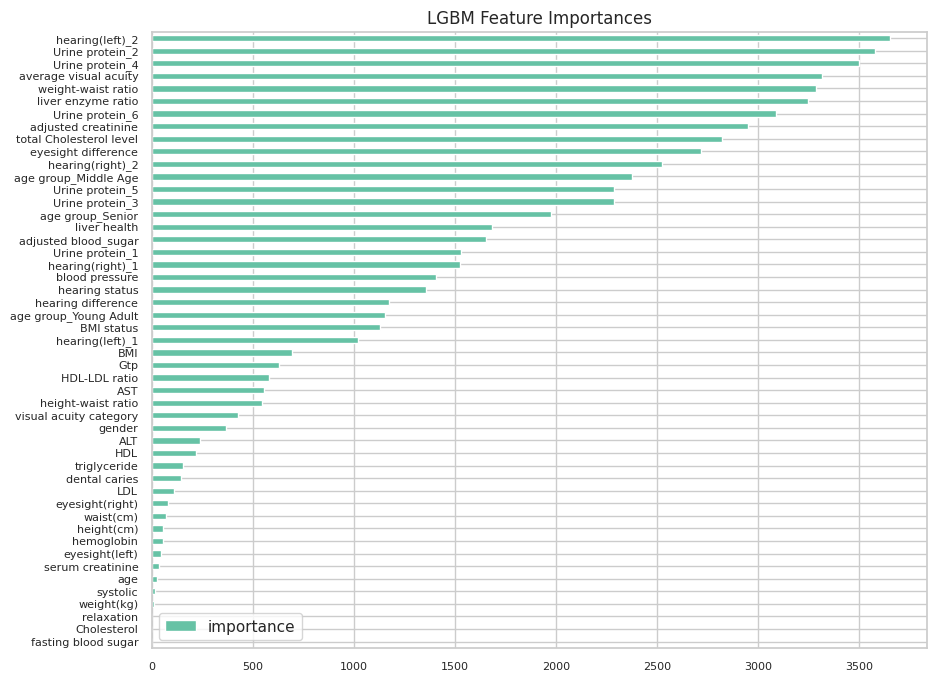

In [95]:
plot_feature_importances(lgbm_base, X_copy.columns, 'LGBM Feature Importances')